## To-do list
* Some cohort exploration based on deletion of subjects

* Look at variable correlations & clustering (if possible) -- suspect eg that systolic/diastolic will cluster based on prev work & means we can get away with using a variable score or one but not the other

* Create initial kitchen-sink model(s)
    * Identifier variables: ruid, visit_id, admit_date, discharge_date
    * Outcome variables: **readmit_30d**, readmit_time
    * Fixed effects (initially): ICD9, CPTs, medications, race, stay length, sex, DOB/age, pregnancy indicator, bmi
    * Random effects (initially): labs, number of transfers
    * Try as both: # transfers, stay length
    
    
* Do one model with all fixed effects first

* Model checking!!

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import bambi as bm
sns.set()

from sklearn import preprocessing, model_selection
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_auc_score

In [146]:
import warnings
warnings.filterwarnings("ignore", module="mkl_fft")
warnings.filterwarnings("ignore", module="matplotlib")

In [166]:
df = pd.read_csv('../data/merged.csv', parse_dates=['admit_date','discharge_date','dob','dod'])

In [167]:
hosp_dates = df.admit_date.dt
birthdays = df.dob.dt

# df['age'] = [hosp_dates.year - birthdays.year + ((hosp_dates.month < birthdays.month) & (hosp_dates.day < birthdays.day))]
times = zip(hosp_dates.year,hosp_dates.month,hosp_dates.day,birthdays.year,birthdays.month,birthdays.day)
df['age'] = [hyear - byear + ((hmon, hday) < (bmon, bday)) for (hyear,hmon,hday,byear,bmon,bday) in times]

In [168]:
df.sex = (df.sex == 'M')*1
df.race = df.race.astype('category')

In [191]:
df[df.readmit_30d.isna()]

Empty DataFrame
Columns: [ruid, visit_id, admit_date, discharge_date, stay_length, n_transfers, readmit_time, readmit_30d, sex, dob, dod, race, cpt_anesthesia, cpt_eval_manage, cpt_expired, cpt_medicine, cpt_modifier, cpt_path_lab, cpt_radiology, cpt_surgery, cpt_unknown, icd_dx_blood, icd_dx_circulatory, icd_dx_congenital, icd_dx_digestive, icd_dx_endocrine, icd_dx_external, icd_dx_gu, icd_dx_infection, icd_dx_injury, icd_dx_mental, icd_dx_muscskel, icd_dx_neoplasm, icd_dx_nervous, icd_dx_obstetric, icd_dx_perinatal, icd_dx_respiratory, icd_dx_skin, icd_dx_symptoms, icd_proc, icd_visit, med_Antihypertensive Agents, med_Analgesics, Opioid, med_Narcotics, med_Antipyretics, med_Anti-Bacterial Agents, med_Anti-Inflammatory Agents, Non-Steroidal, med_Analgesics, Non-Narcotic, med_Antiemetics, med_Diuretics, med_Anti-Arrhythmia Agents, bun, co2, cl, creat, glubed, gluc, k, na, pcv, plt-ct, systolic, diastolic, bmi, pregnancy_indicator, egfr, age]
Index: []

[0 rows x 67 columns]

In [7]:
df.shape

(21041, 67)

In [8]:
df.columns

Index(['ruid', 'visit_id', 'admit_date', 'discharge_date', 'stay_length',
       'n_transfers', 'readmit_time', 'readmit_30d', 'sex', 'dob', 'dod',
       'race', 'cpt_anesthesia', 'cpt_eval_manage', 'cpt_expired',
       'cpt_medicine', 'cpt_modifier', 'cpt_path_lab', 'cpt_radiology',
       'cpt_surgery', 'cpt_unknown', 'icd_dx_blood', 'icd_dx_circulatory',
       'icd_dx_congenital', 'icd_dx_digestive', 'icd_dx_endocrine',
       'icd_dx_external', 'icd_dx_gu', 'icd_dx_infection', 'icd_dx_injury',
       'icd_dx_mental', 'icd_dx_muscskel', 'icd_dx_neoplasm', 'icd_dx_nervous',
       'icd_dx_obstetric', 'icd_dx_perinatal', 'icd_dx_respiratory',
       'icd_dx_skin', 'icd_dx_symptoms', 'icd_proc', 'icd_visit',
       'med_Antihypertensive Agents', 'med_Analgesics, Opioid',
       'med_Narcotics', 'med_Antipyretics', 'med_Anti-Bacterial Agents',
       'med_Anti-Inflammatory Agents, Non-Steroidal',
       'med_Analgesics, Non-Narcotic', 'med_Antiemetics', 'med_Diuretics',
       'med_A

In [11]:
labs = ['bun', 'co2', 'cl', 'creat', 'glubed',
       'gluc', 'k', 'na', 'pcv', 'plt-ct', 'systolic', 'diastolic', 'egfr']

demo = ['sex', 'age', 'bmi', 'pregnancy_indicator', 'race']

visit = ['stay_length', 'n_transfers', 'cpt_anesthesia', 'cpt_eval_manage', 'cpt_expired',
       'cpt_medicine', 'cpt_modifier', 'cpt_path_lab', 'cpt_radiology',
       'cpt_surgery', 'cpt_unknown']

diagnosis = ['icd_dx_blood', 'icd_dx_circulatory',
       'icd_dx_congenital', 'icd_dx_digestive', 'icd_dx_endocrine',
       'icd_dx_external', 'icd_dx_gu', 'icd_dx_infection', 'icd_dx_injury',
       'icd_dx_mental', 'icd_dx_muscskel', 'icd_dx_neoplasm', 'icd_dx_nervous',
       'icd_dx_obstetric', 'icd_dx_perinatal', 'icd_dx_respiratory',
       'icd_dx_skin', 'icd_dx_symptoms', 'icd_proc', 'icd_visit']

meds = ['med_Antihypertensive Agents', 'med_Analgesics, Opioid',
       'med_Narcotics', 'med_Antipyretics', 'med_Anti-Bacterial Agents',
       'med_Anti-Inflammatory Agents, Non-Steroidal',
       'med_Analgesics, Non-Narcotic', 'med_Antiemetics', 'med_Diuretics',
       'med_Anti-Arrhythmia Agents']

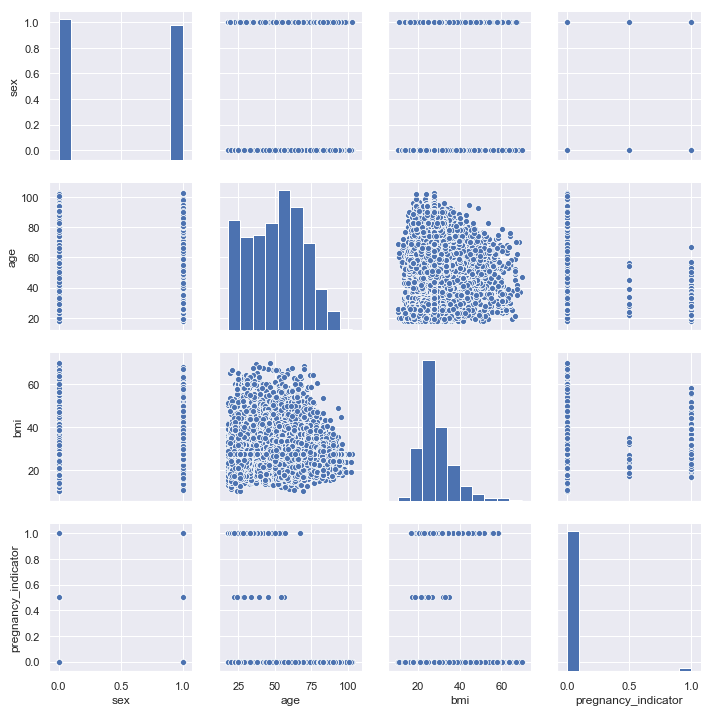

In [9]:
sns.pairplot(df[demo]);

In [10]:
df[((df.sex == 1) & (df.pregnancy_indicator == 1)) | ((df.sex == 1) & (df.pregnancy_indicator == 1)).shift() | ((df.sex == 1) & (df.pregnancy_indicator == 1)).shift(-1)]

ruid  visit_id admit_date discharge_date  \
2282   53728500         0 2006-05-06     2006-05-09   
2283   53728502         0 2004-10-28     2004-11-02   
2284   53728502         1 2005-01-19     2005-01-26   
2285   53728502         2 2005-11-29     2005-12-02   
5965   53730004         5 2010-01-05     2010-01-08   
5966   53730004         6 2010-03-03     2010-03-08   
5967   53730004         7 2010-04-03     2010-04-28   
5968   53730004         8 2010-05-09     2010-05-15   
5969   53730004         9 2010-06-03     2010-06-24   
5970   53730004        10 2010-07-26     2010-07-29   
5971   53730006         0 2010-07-10     2010-07-14   
13245  53733098        13 2008-08-20     2008-08-23   
13246  53733103         0 2005-05-15     2005-05-21   
13247  53733103         1 2005-07-13     2005-07-18   
14925  53733832         1 2011-03-08     2011-03-12   
14926  53733834         0 2006-01-30     2006-02-07   
14927  53733834         1 2006-02-23     2006-02-24   
14928  53733834         2 2006-06-25     2006-06-29   
14929  53733834         3 2007-01-25     2007-01-27   
14930  53733834         4 2008-04-14     2008-04-16   
18778  53735481         0 2005-02-02     2005-03-23   
18779  53735481         1 2005-03-30     2005-04-06   
18780  53735481         2 2005-04-08     2005-04-13   

                      stay_length  n_transfers                  readmit_time  \
2282    3 days 00:00:00.000000000            1  9999 days 00:00:00.000000000   
2283    5 days 00:00:00.000000000            1    78 days 00:00:00.000000000   
2284    7 days 00:00:00.000000000            5   307 days 00:00:00.000000000   
2285    3 days 00:00:00.000000000            1    26 days 00:00:00.000000000   
5965    3 days 00:00:00.000000000            1    54 days 00:00:00.000000000   
5966    5 days 00:00:00.000000000            3    26 days 00:00:00.000000000   
5967   25 days 00:00:00.000000000           17    11 days 00:00:00.000000000   
5968    6 days 00:00:00.000000000            4    19 days 00:00:00.000000000   
5969   21 days 00:00:00.000000000           15    32 days 00:00:00.000000000   
5970    3 days 00:00:00.000000000            4  9999 days 00:00:00.000000000   
5971    4 days 00:00:00.000000000            1   121 days 00:00:00.000000000   
13245   3 days 00:00:00.000000000            2  9999 days 00:00:00.000000000   
13246   6 days 00:00:00.000000000            2    53 days 00:00:00.000000000   
13247   5 days 00:00:00.000000000            1   581 days 00:00:00.000000000   
14925   4 days 00:00:00.000000000            1  9999 days 00:00:00.000000000   
14926   8 days 00:00:00.000000000            4    16 days 00:00:00.000000000   
14927   1 days 00:00:00.000000000            1   121 days 00:00:00.000000000   
14928   4 days 00:00:00.000000000            2   210 days 00:00:00.000000000   
14929   2 days 00:00:00.000000000            1   443 days 00:00:00.000000000   
14930   2 days 00:00:00.000000000            1   172 days 00:00:00.000000000   
18778  49 days 00:00:00.000000000            7     7 days 00:00:00.000000000   
18779   7 days 00:00:00.000000000            3     2 days 00:00:00.000000000   
18780   5 days 00:00:00.000000000            1    17 days 00:00:00.000000000   

       readmit_30d  sex        dob ...      k     na   pcv  plt-ct  systolic  \
2282             0    0 1943-07-18 ...   3.40  138.5  39.5   191.5     130.0   
2283             0    1 1949-10-25 ...   4.10  136.0  35.0   323.0     126.0   
2284             0    1 1949-10-25 ...   3.70  131.5  28.0   274.0     126.0   
2285             1    1 1949-10-25 ...   4.30  137.0  28.0   294.0     128.0   
5965             0    1 1972-05-05 ...   4.95  139.5  35.0   404.0     140.5   
5966             1    1 1972-05-05 ...   4.55  138.0  35.0   160.0     111.0   
5967             1    1 1972-05-05 ...   3.95  137.0  26.0   623.0     127.0   
5968             1    1 1972-05-05 ...   4.40  139.0  36.5   349.0     122.0   
5969             0    1 1972-05-05 ...   4.20  13

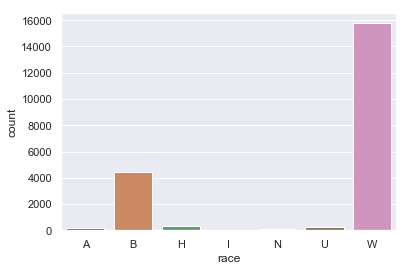

In [14]:
sns.countplot(df.race);

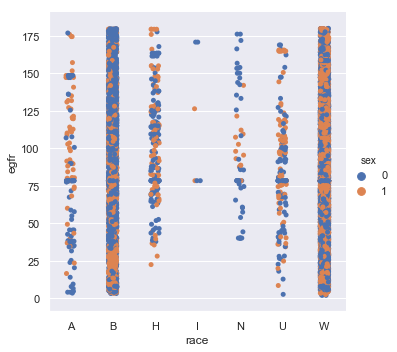

In [23]:
sns.catplot(x = 'race', y = 'egfr', hue='sex', data=df);

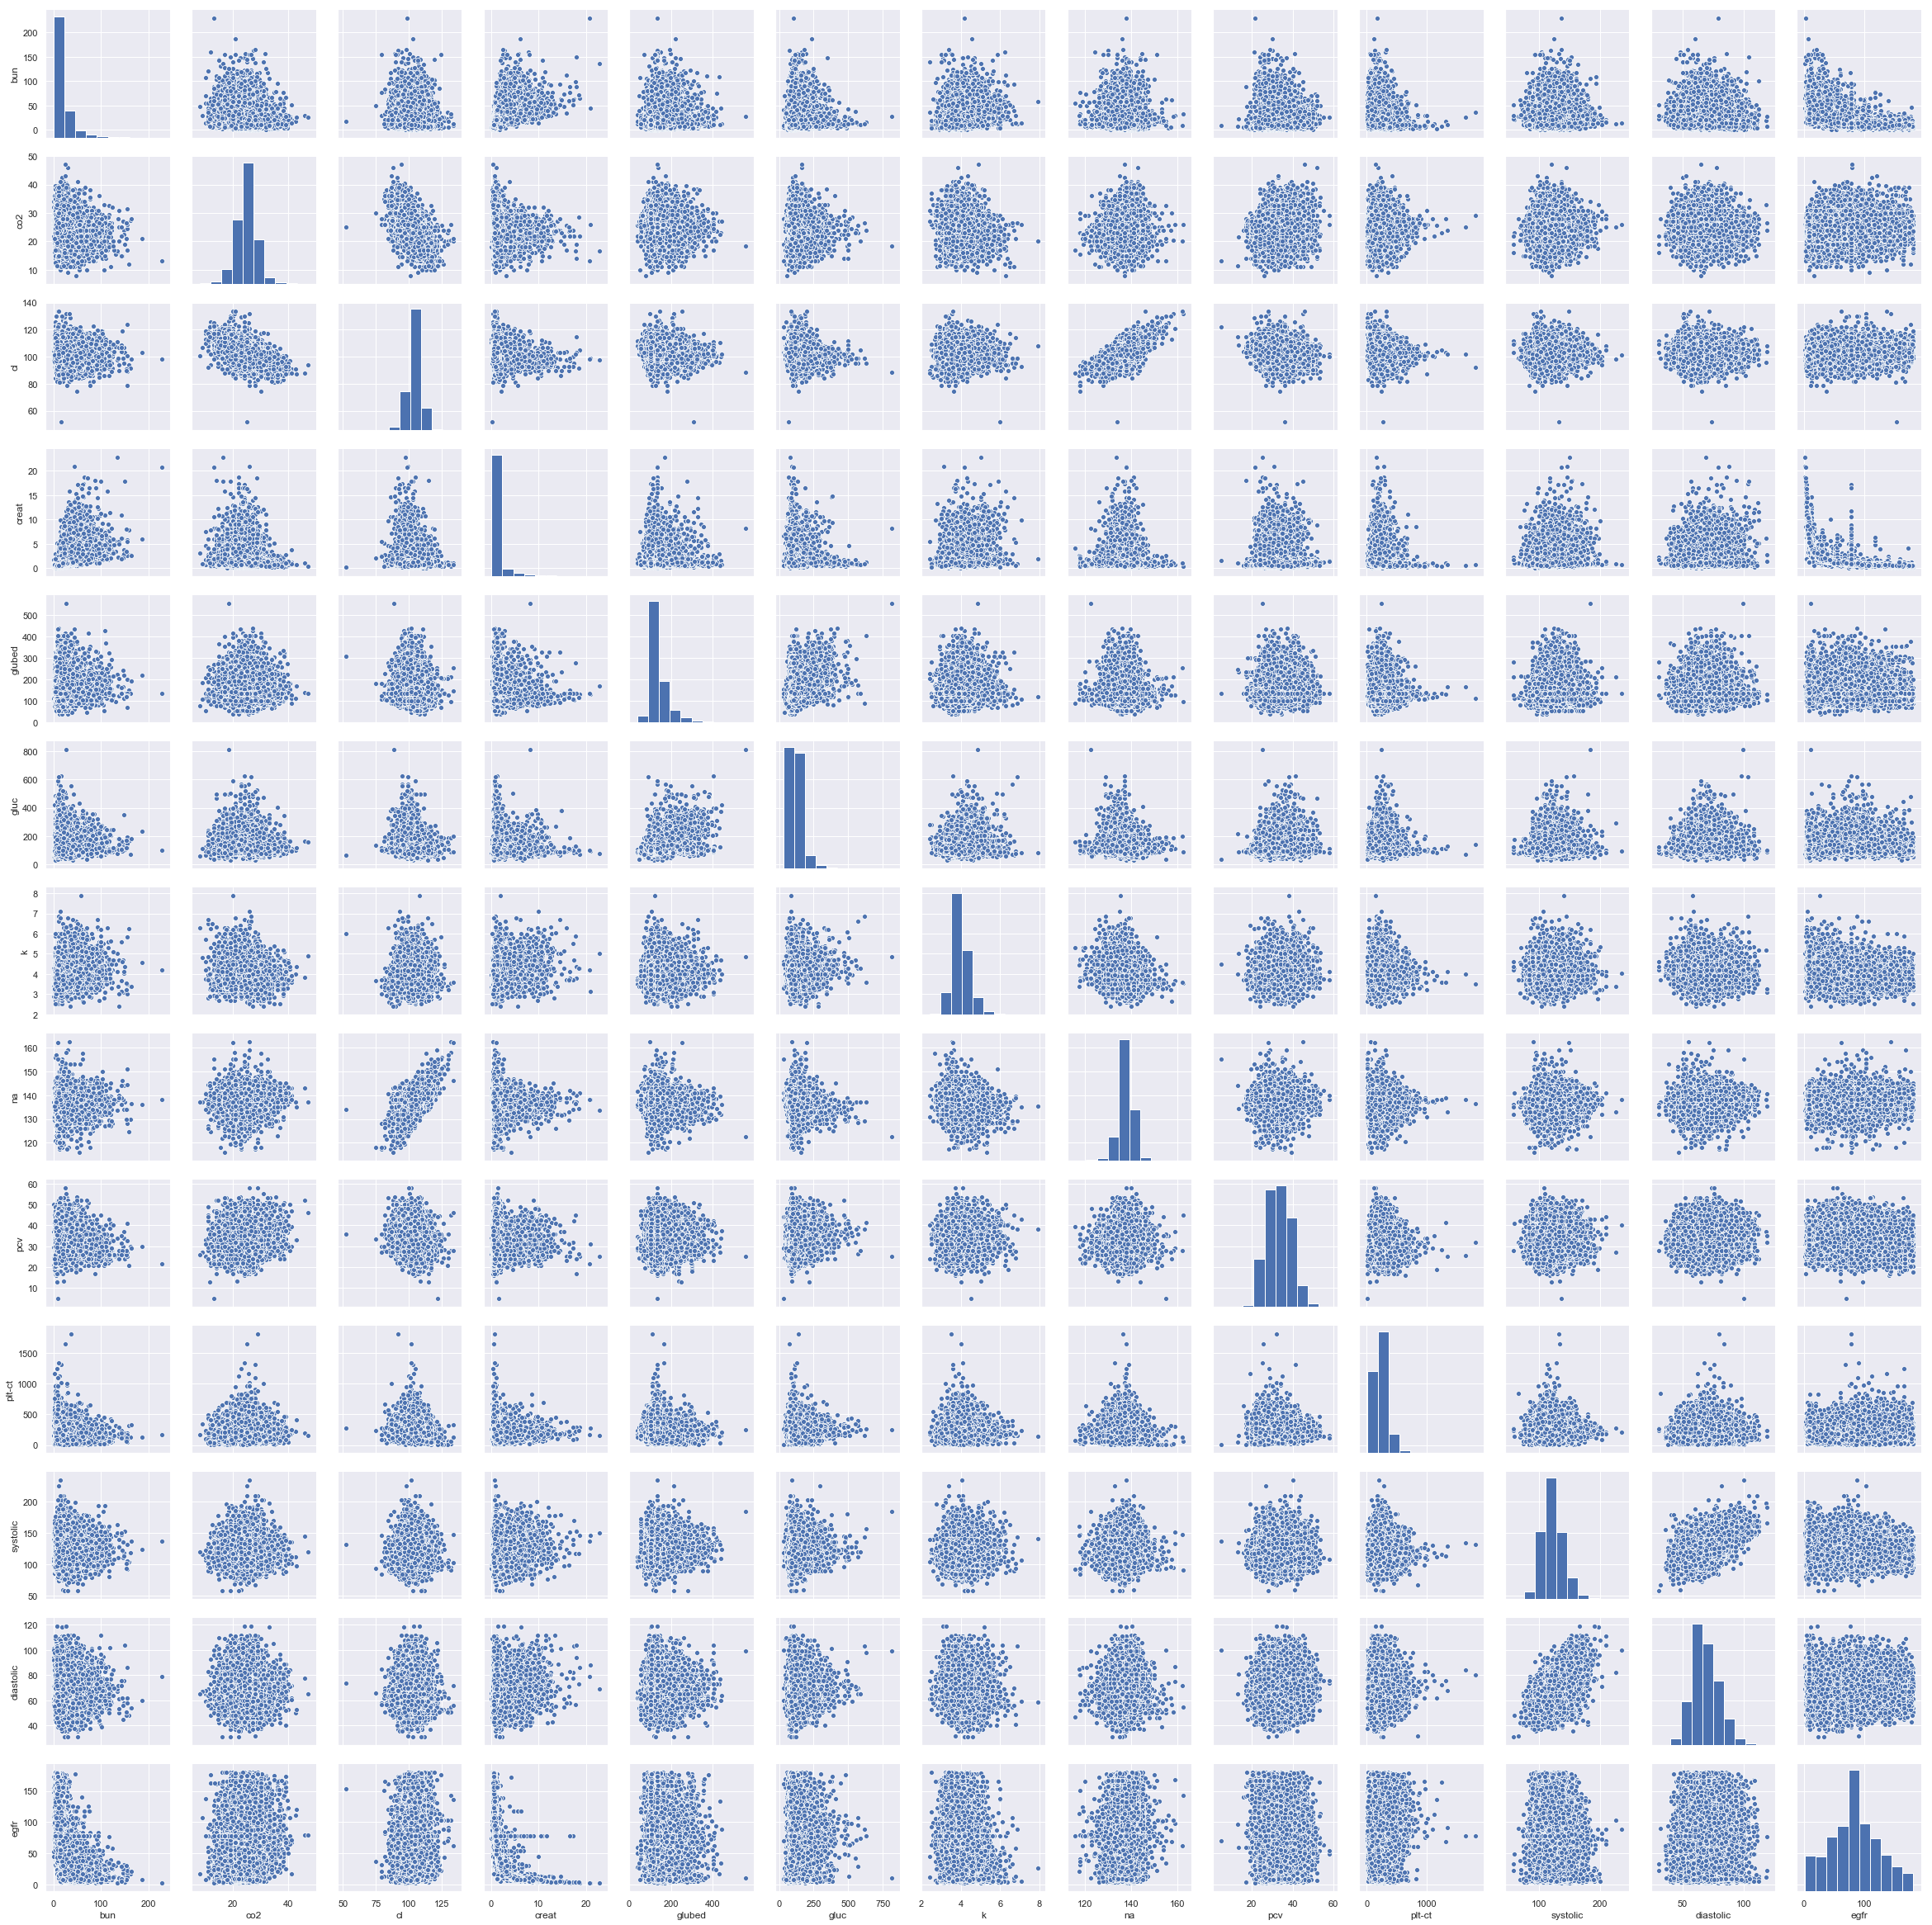

In [22]:
sns.pairplot(df[labs]);

In [25]:
# minimal_model = bm.Model(df)

# form = 'readmit_30d ~ ' + ' + '.join(demo)

# minimal_model.add('readmit_30d ~ 1')

# minimal_model.add(fixed = ' + '.join(demo))

In [107]:
y = df.readmit_30d[~(df.bmi.isna())]
X = df[~(df.bmi.isna())][demo]
X = pd.get_dummies(X)
X.loc[X.pregnancy_indicator.isna(),'pregnancy_indicator'] = 0
bmi = X.pop('bmi').values
bmi = bmi - np.nanmean(bmi)
X = X.values
X.shape

(18804, 10)

In [110]:
ruids = df.ruid.unique() # need to make this a dict for accessing repeated values somehow ... 
ruid_lookup = dict(zip(ruids, range(len(ruids))))
ruid = df['ruid_code'] = df.ruid.replace(ruid_lookup).values
ruid_red = ruid[~(df.bmi.isna())]
N = len(ruids)

In [56]:
np.sqrt(np.nanvar(bmi))

7.800283739906926

In [111]:
with pm.Model() as minimal_model:
    
    μ = pm.Normal("μ",0,sd=5)
    β = pm.Normal("β",0,sd=5,shape=X.shape[1])
    
    b_bmi = pm.Normal('b_bmi',0,10, shape = N)
    
    p = pm.invlogit(μ + β.dot(X.T) + b_bmi[ruid_red]*bmi)
    
    readmit_30d = pm.Bernoulli('30day_readmit', p=p, observed = y)

In [ ]:
    μ = pm.Normal("μ",0,sd=5)
    β = pm.Normal("β",0,sd=5,shape=X.shape[1])
    b_age = pm.Normal('b_age', 0, sd = 5)
    
    p = pm.invlogit(μ + β.dot(X.T) + b_age*age_imputed)
    
    survived = pm.Bernoulli('survived', p=p, observed=y)

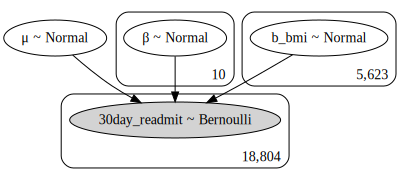

In [112]:
pm.model_to_graphviz(minimal_model)

In [113]:
with minimal_model:
    test_trace = pm.sample(200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_bmi, β, μ]
Sampling 2 chains: 100%|██████████| 1400/1400 [31:17<00:00,  1.35s/draws]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


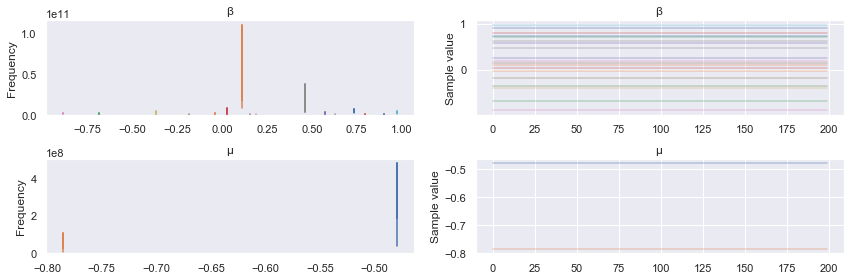

In [114]:
pm.traceplot(test_trace, varnames = ['β','μ']);

In [195]:
data = df[~(df.bmi.isna())][demo + ['readmit_30d']]
data = pd.get_dummies(data)
data.loc[data.pregnancy_indicator.isna(),'pregnancy_indicator'] = 0
data

sex  age     bmi  pregnancy_indicator  readmit_30d  race_A  race_B  \
0        0   59  44.710                  0.0            0       0       0   
1        0   59  45.025                  0.0            1       0       0   
2        0   59  46.230                  0.0            0       0       0   
3        0   60  47.140                  0.0            0       0       0   
4        0   60  47.360                  0.0            0       0       0   
5        0   61  47.580                  0.0            0       0       0   
6        0   63  40.200                  0.0            0       0       0   
7        0   64  44.250                  0.0            0       0       0   
8        0   64  42.770                  0.0            0       0       0   
9        0   65  48.340                  0.0            0       0       0   
10       1   75  32.550                  0.0            0       0       0   
11       1   76  32.410                  0.0            0       0       0   
12       1   76  33.780                  0.0            1       0       0   
13       1   76  31.530                  0.0            1       0       0   
14       1   76  31.530                  0.0            1       0       0   
15       1   76  30.190                  0.0            0       0       0   
16       1   77  31.550                  0.0            1       0       0   
17       1   77  31.670                  0.0            0       0       0   
18       1   79  32.780                  0.0            1       0       0   
19       1   79  29.410                  0.0            0       0       0   
20       1   81  27.680                  0.0            0       0       0   
21       1   80  32.555                  0.0            1       0       0   
22       1   80  32.920                  0.0            0       0       0   
23       1   80  28.010                  0.0            0       0       0   
24       1   46  26.460                  0.0            0       0       0   
25       1   48  26.460                  0.0            0       0       0   
26       1   49  26.460                  0.0            1       0       0   
27       1   49  26.460                  0.0            0       0       0   
28       1   50  28.325                  0.0            0       0       0   
29       1   50  27.350                  0.0            0       0       0   
...    ...  ...     ...                  ...          ...     ...     ...   
21008    0   34  27.510                  0.0            0       0       0   
21009    0   44  27.510                  0.0            0       0       0   
21010    0   29  27.510                  0.0            0       0       0   
21011    1   59  30.990                  0.0            0       0       1   
21012    1   61  30.990                  0.0            0       0       1   
21013    1   62  30.990                  0.0            1       0       1   
21014    1   62  30.990                  0.0            0       0       1   
21015    1   62  30.990                  0.0            0       0       1   
21016    1   63  24.910                  0.0            0       0       1   
21017    1   65  24.910                  0.0            1       0       1   
21019    1   66  24.910                  0.0            0       0       1   
21020    0   61  27.510                  0.0            0       0       0   
21021    0   64  27.510                  0.0            0       1       0   
21022    1   26  27.510                  0.0            0       0       0   
21023    1   26  27.510                  0.0            0       0       0   
21025    0   56  17.630                  0.0            0       0       1   
21026    0   56  17.630                  0.0            0       0       1   
21027    0   56  17.630                  0.0            0       0       1   
21028    0   46  22.130                  0.0            0       0       0   
21029    0   33  27.510                  0.0            0       0       0   
210

In [204]:
form = 'readmit_30d ~ ' + ' + '.join(data.columns[(data.columns != 'readmit_30d')])
form

'readmit_30d ~ sex + pregnancy_indicator + race_A + race_B + race_H + race_I + race_N + race_U + race_W + age_trns + bmi_trns'

In [142]:
with pm.Model() as fixed_effects:
    family = pm.glm.families.Binomial()
    pm.glm.GLM.from_formula(form,data,family=family)

In [143]:
for RV in fixed_effects.basic_RVs:
    print(RV.name, RV.logp(fixed_effects.test_point))

Intercept 0.0
sex -7.82669381218681
age -7.82669381218681
bmi -7.82669381218681
pregnancy_indicator -7.82669381218681
race_A -7.82669381218681
race_B -7.82669381218681
race_H -7.82669381218681
race_I -7.82669381218681
race_N -7.82669381218681
race_U -7.82669381218681
race_W -7.82669381218681
y -13033.939583251822


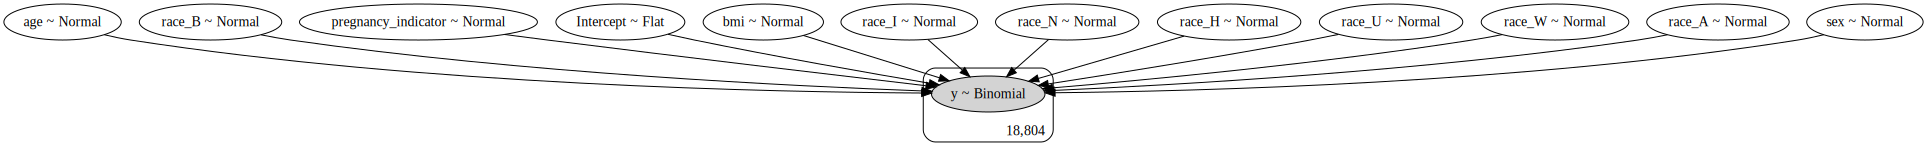

In [185]:
pm.model_to_graphviz(fixed_effects)

In [144]:
with fixed_effects:    
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [race_W, race_U, race_N, race_I, race_H, race_B, race_A, pregnancy_indicator, bmi, age, sex, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [27:19<00:00,  1.22draws/s]
The acceptance probability does not match the target. It is 0.5541887126793166, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.3983966404203111, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameter

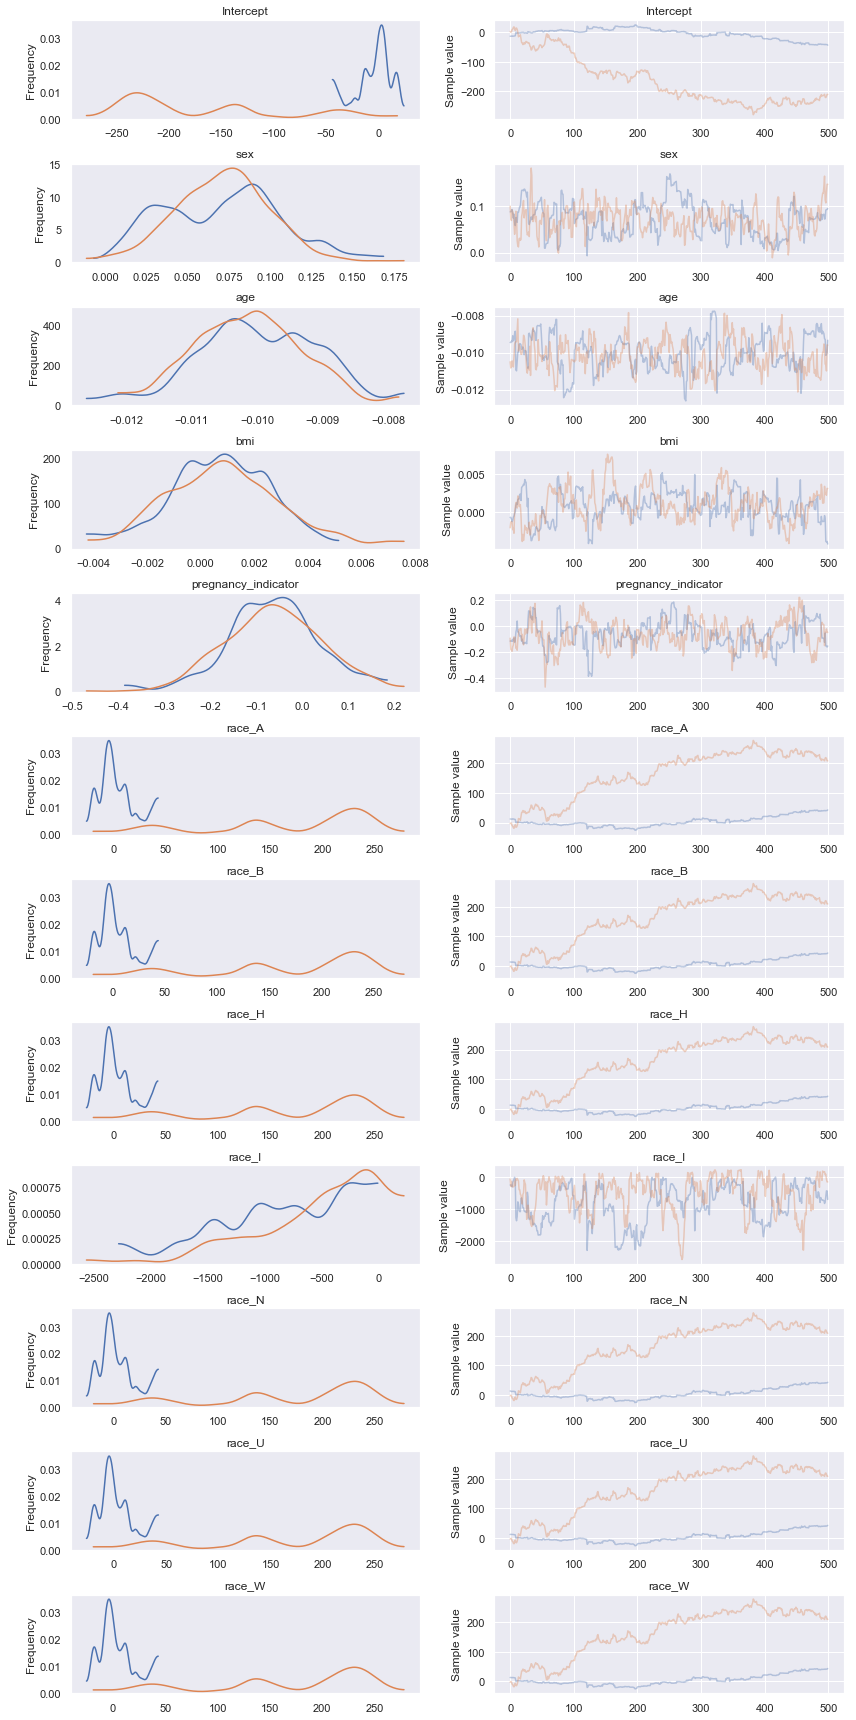

In [147]:
pm.traceplot(trace);

/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


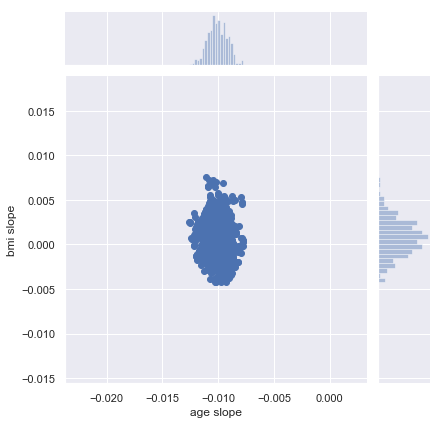

In [148]:
x = pd.Series(trace['age'], name='age slope')
y = pd.Series(trace['bmi'], name='bmi slope')

sns.jointplot(x, y);

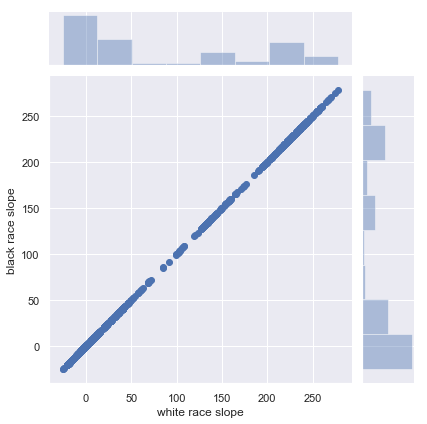

In [183]:
x = pd.Series(trace['race_W'], name='white race slope')
y = pd.Series(trace['race_B'], name='black race slope')

sns.jointplot(x, y);

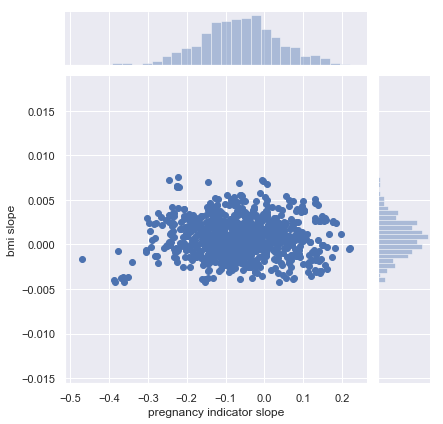

In [184]:
x = pd.Series(trace['pregnancy_indicator'], name='pregnancy indicator slope')
y = pd.Series(trace['bmi'], name='bmi slope')

sns.jointplot(x, y);

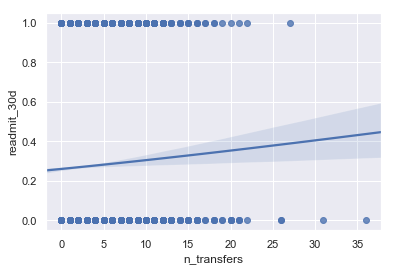

In [153]:
sns.regplot(x= 'n_transfers', y= 'readmit_30d', data= df, logistic= True);

In [152]:
df[demo].describe()

sex           age           bmi  pregnancy_indicator
count  21041.000000  21041.000000  18804.000000         18804.000000
mean       0.490186     50.630816     28.709525             0.022681
std        0.499916     18.714957      7.800491             0.148398
min        0.000000     18.000000     10.130000             0.000000
25%        0.000000     35.000000     23.640000             0.000000
50%        0.000000     52.000000     27.510000             0.000000
75%        1.000000     64.000000     31.921250             0.000000
max        1.000000    103.000000     69.790000             1.000000

In [172]:
df_nooc = df.copy()

In [175]:
df_nooc = df_nooc.drop(["ruid","visit_id","admit_date","discharge_date",
                        "readmit_time","readmit_30d"], axis=1)

In [176]:
df_nooc.columns

Index(['stay_length', 'n_transfers', 'sex', 'dob', 'dod', 'race',
       'cpt_anesthesia', 'cpt_eval_manage', 'cpt_expired', 'cpt_medicine',
       'cpt_modifier', 'cpt_path_lab', 'cpt_radiology', 'cpt_surgery',
       'cpt_unknown', 'icd_dx_blood', 'icd_dx_circulatory',
       'icd_dx_congenital', 'icd_dx_digestive', 'icd_dx_endocrine',
       'icd_dx_external', 'icd_dx_gu', 'icd_dx_infection', 'icd_dx_injury',
       'icd_dx_mental', 'icd_dx_muscskel', 'icd_dx_neoplasm', 'icd_dx_nervous',
       'icd_dx_obstetric', 'icd_dx_perinatal', 'icd_dx_respiratory',
       'icd_dx_skin', 'icd_dx_symptoms', 'icd_proc', 'icd_visit',
       'med_Antihypertensive Agents', 'med_Analgesics, Opioid',
       'med_Narcotics', 'med_Antipyretics', 'med_Anti-Bacterial Agents',
       'med_Anti-Inflammatory Agents, Non-Steroidal',
       'med_Analgesics, Non-Narcotic', 'med_Antiemetics', 'med_Diuretics',
       'med_Anti-Arrhythmia Agents', 'bun', 'co2', 'cl', 'creat', 'glubed',
       'gluc', 'k', 'na', '

In [177]:
df_nooc.corr()

n_transfers       sex  \
n_transfers                                     1.000000  0.047886   
sex                                             0.047886  1.000000   
cpt_anesthesia                                  0.150987  0.006868   
cpt_eval_manage                                 0.527980  0.030870   
cpt_expired                                     0.388557  0.055642   
cpt_medicine                                    0.516122  0.038771   
cpt_modifier                                    0.470775  0.031728   
cpt_path_lab                                    0.529798  0.064289   
cpt_radiology                                   0.514313  0.065720   
cpt_surgery                                     0.443901  0.020999   
cpt_unknown                                     0.078095 -0.034791   
icd_dx_blood                                    0.289859  0.009433   
icd_dx_circulatory                              0.359061  0.078341   
icd_dx_congenital                               0.053734  0.002457   
icd_dx_digestive                                0.216130  0.012190   
icd_dx_endocrine                                0.378648  0.003469   
icd_dx_external                                 0.206950  0.049159   
icd_dx_gu                                       0.392611  0.006869   
icd_dx_infection                                0.437627  0.037791   
icd_dx_injury                                   0.432933  0.058818   
icd_dx_mental                                   0.137856  0.006890   
icd_dx_muscskel                                 0.159073 -0.011767   
icd_dx_neoplasm                                 0.114035  0.031989   
icd_dx_nervous                                  0.193516  0.024449   
icd_dx_obstetric                                0.029555 -0.140938   
icd_dx_perinatal                                0.004458 -0.016687   
icd_dx_respiratory                              0.431176  0.034689   
icd_dx_skin                                     0.138909  0.030464   
icd_dx_symptoms                                 0.456254  0.028059   
icd_proc                                        0.353484  0.057330   
icd_visit                                       0.431965  0.047802   
med_Antihypertensive Agents                     0.345365  0.046633   
med_Analgesics, Opioid                          0.417255  0.028042   
med_Narcotics                                   0.402644  0.030439   
med_Antipyretics                                0.393698  0.064059   
med_Anti-Bacterial Agents                       0.398159  0.049804   
med_Anti-Inflammatory Agents, Non-Steroidal     0.339082  0.040957   
med_Analgesics, Non-Narcotic                    0.379403  0.001167   
med_Antiemetics                                 0.325938  0.004781   
med_Diuretics                                   0.265180  0.051959   
med_Anti-Arrhythmia Agents                      0.348538  0.069351   
bun                                             0.122089  0.119831   
co2                                            -0.029139  0.039698   
cl                                             -0.038206 -0.090445   
creat                                           0.119208  0.106363   
glubed                                         -0.025907  0.030999   
gluc                                           -0.006545  0.049344   
k                                               0.023599  0.105486   
na                                             -0.018303 -0.064349   
pcv                                            -0.154198  0.153248   
plt-ct                                         -0.018384 -0.085301   
systolic                                       -0.014915  0.035123   
diastolic                                      -0.076706  0.106535   
bmi                                            -0.000466 -0.080561   
pregnancy_indicator                            -0.011179 -0.142023   
egfr                                           -0.089592 -0.024731   
age                                             0.04043

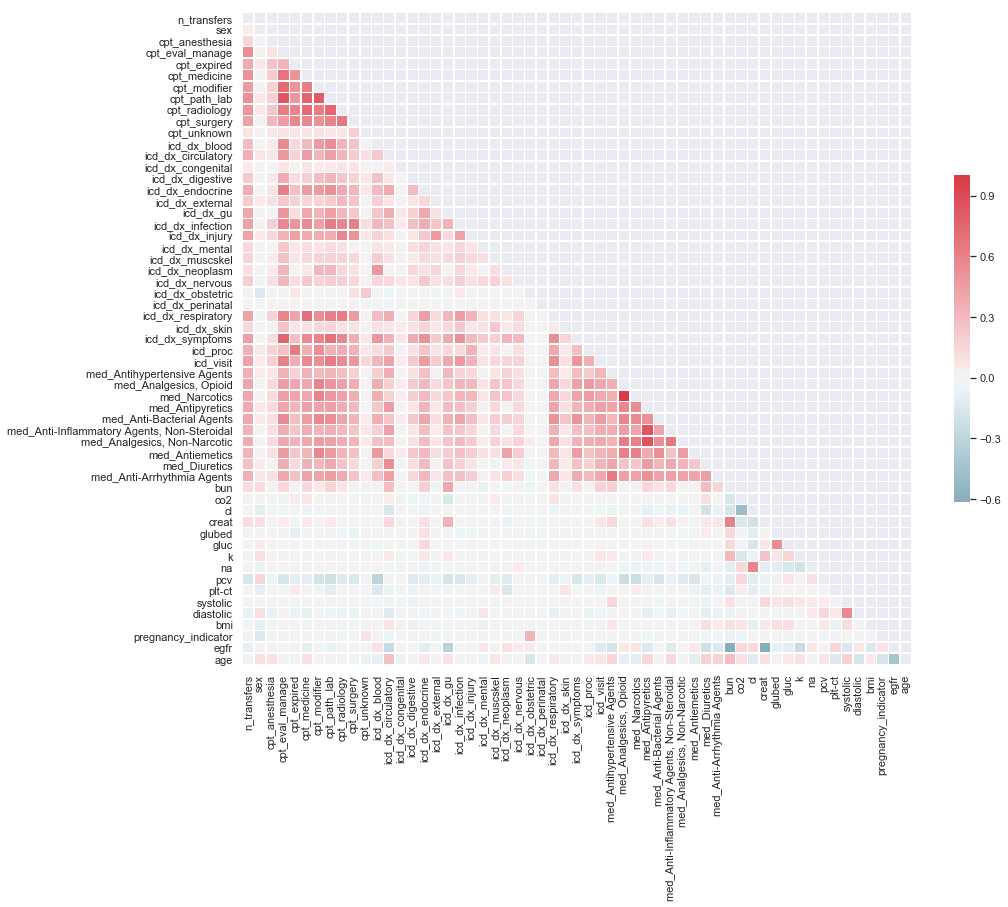

In [181]:
corr = df_nooc.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, center = 0);

In [203]:
scaler = preprocessing.StandardScaler()
scaler.fit(data[["age","bmi"]])
trns = scaler.transform(data[["age","bmi"]])
data['age_trns'] = trns.T[0]
data['bmi_trns'] = trns.T[1]

/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [204]:
form = 'readmit_30d ~ ' + ' + '.join(data.columns[(data.columns != 'readmit_30d')])
form

'readmit_30d ~ sex + pregnancy_indicator + race_A + race_B + race_H + race_I + race_N + race_U + race_W + age_trns + bmi_trns'

In [205]:
with pm.Model() as transformed_model:
    family = pm.glm.families.Binomial()
    pm.glm.GLM.from_formula(form,data,family=family)

In [207]:
for RV in transformed_model.basic_RVs:
    print(RV.name, RV.logp(transformed_model.test_point))

Intercept 0.0
sex -7.82669381218681
pregnancy_indicator -7.82669381218681
race_A -7.82669381218681
race_B -7.82669381218681
race_H -7.82669381218681
race_I -7.82669381218681
race_N -7.82669381218681
race_U -7.82669381218681
race_W -7.82669381218681
age_trns -7.82669381218681
bmi_trns -7.82669381218681
y -13033.939583251822


In [208]:
with transformed_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bmi_trns, age_trns, race_W, race_U, race_N, race_I, race_H, race_B, race_A, pregnancy_indicator, sex, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [29:33<00:00,  1.60s/draws]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8791710688398203, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c58f64fd0>,
      dtype=object)

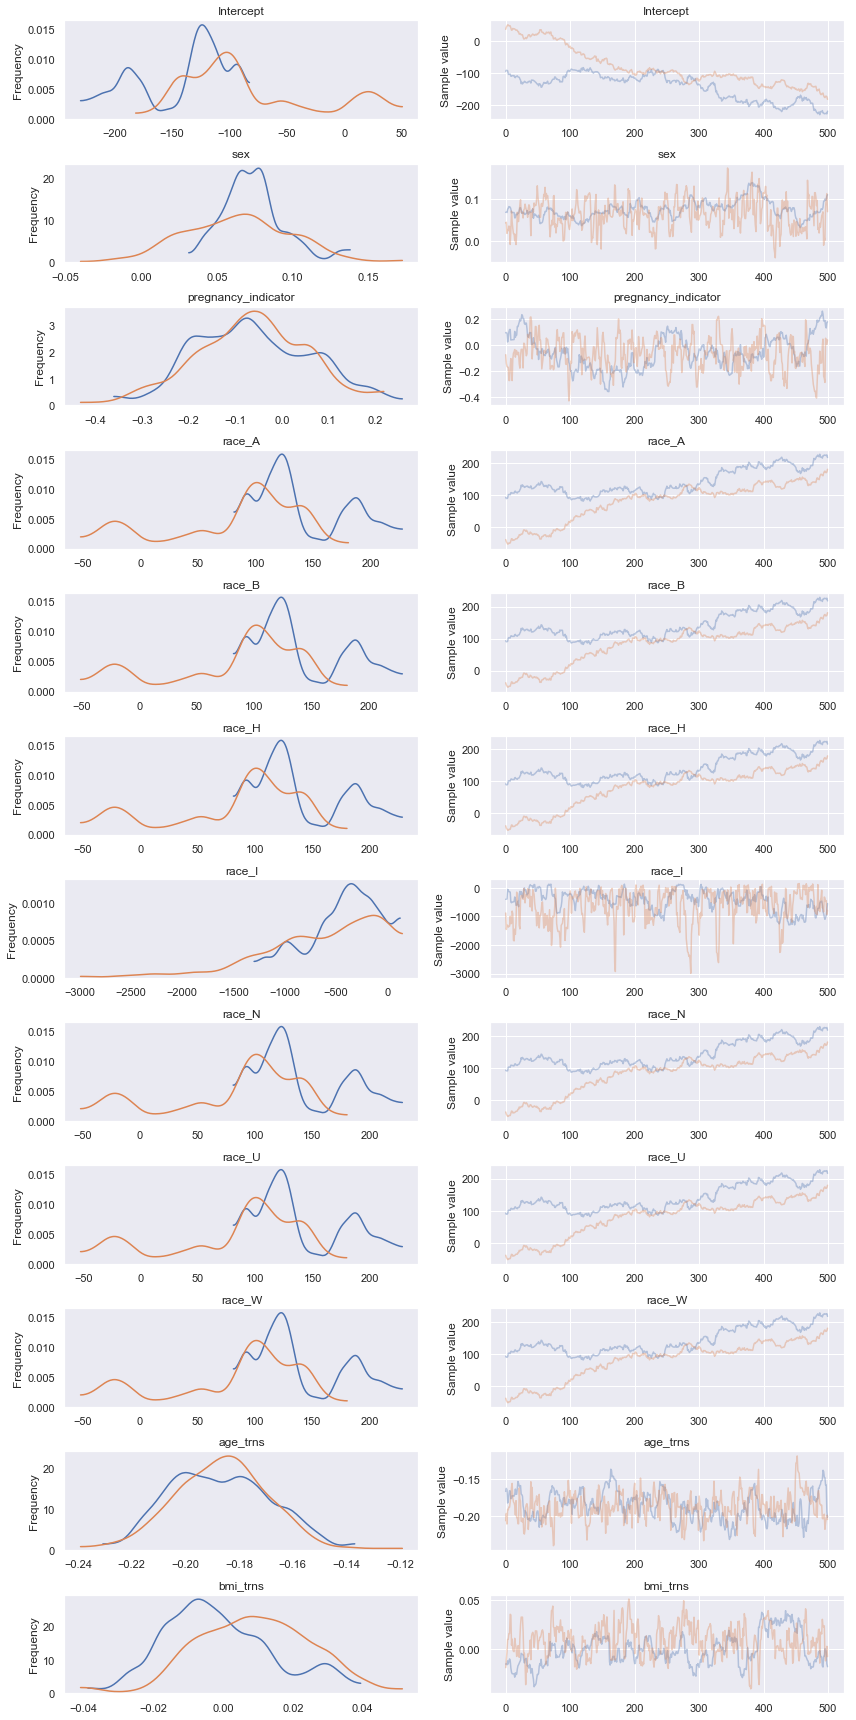

In [209]:
pm.traceplot(trace);

GridSpec(1, 2, width_ratios=[3, 1])

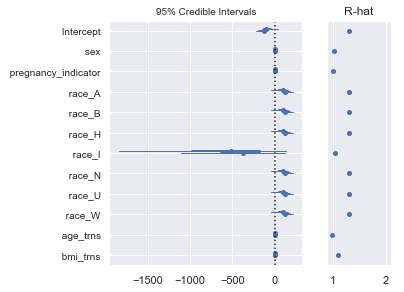

In [210]:
pm.forestplot(trace);

In [212]:
data_red = data[["readmit_30d","age_trns","bmi_trns","sex","pregnancy_indicator"]]

In [213]:
form = 'readmit_30d ~ ' + ' + '.join(data_red.columns[(data_red.columns != 'readmit_30d')])
form

'readmit_30d ~ age_trns + bmi_trns + sex + pregnancy_indicator'

In [214]:
with pm.Model() as reduced_model:
    family = pm.glm.families.Binomial()
    pm.glm.GLM.from_formula(form,data_red,family=family)
    
    trace_red = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pregnancy_indicator, sex, bmi_trns, age_trns, Intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:31<00:00, 62.65draws/s]


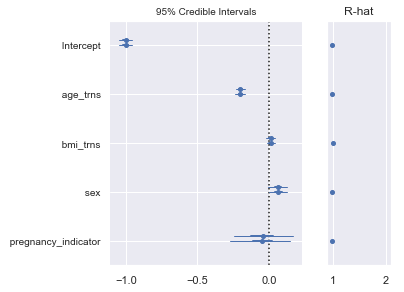

In [215]:
pm.forestplot(trace_red);

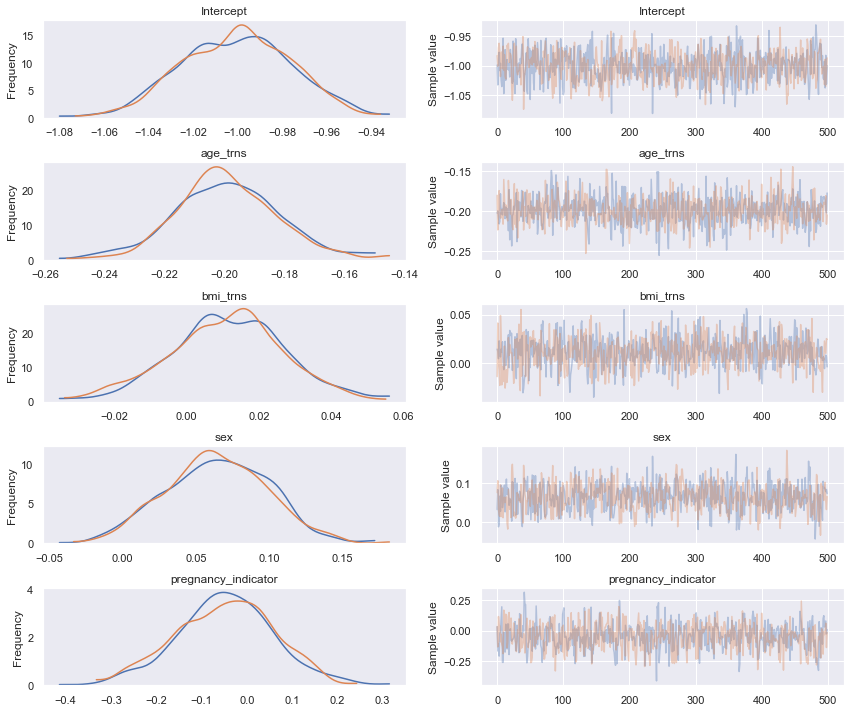

In [216]:
pm.traceplot(trace_red);

In [217]:
y = df.readmit_30d[~(df.bmi.isna())]
X = df[~(df.bmi.isna())][["age","bmi","pregnancy_indicator","sex"]]
X.loc[X.pregnancy_indicator.isna(),'pregnancy_indicator'] = 0
bmi = X.pop('bmi').values
bmi = bmi - np.nanmean(bmi)
X = X.values
X.shape

(18804, 3)

In [218]:
ruids = df.ruid.unique() # need to make this a dict for accessing repeated values somehow ... 
ruid_lookup = dict(zip(ruids, range(len(ruids))))
ruid = df['ruid_code'] = df.ruid.replace(ruid_lookup).values
ruid_red = ruid[~(df.bmi.isna())]
N = len(ruids)

In [220]:
with pm.Model() as minimal_model:
    
    μ = pm.Normal("μ",0,sd=5)
    β = pm.Normal("β",0,sd=5,shape=X.shape[1])
    
    b_bmi = pm.Normal('b_bmi',0,10, shape = N)
    
    p = pm.invlogit(μ + β.dot(X.T) + b_bmi[ruid_red]*bmi)
    
    readmit_30d = pm.Bernoulli('30day_readmit', p=p, observed = y)

In [221]:
with minimal_model:
    min_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_bmi, β, μ]
Sampling 2 chains: 100%|██████████| 2000/2000 [39:57<00:00,  1.80s/draws]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6676880653158436, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


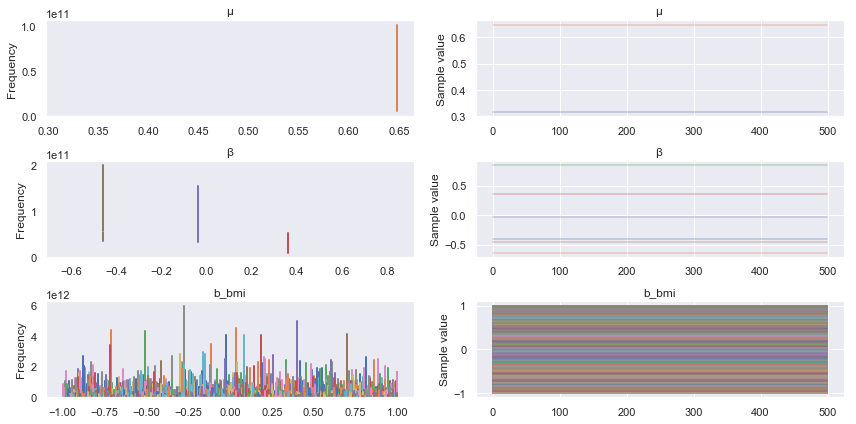

In [223]:
pm.traceplot(min_trace);

Okay I have to concede that the model hierarchical on patients just isn't going to work right; there's too many of them and not enough data to fit it.

GridSpec(1, 2, width_ratios=[3, 1])

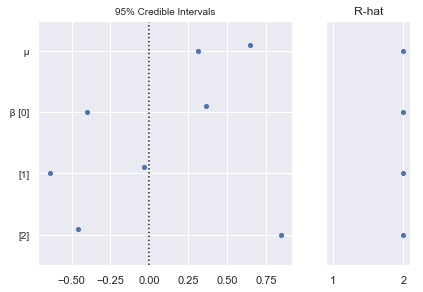

In [228]:
pm.forestplot(min_trace,varnames=['μ','β'])

## For a general modeling pipeline:
Need a utility function that:
1. Takes a DF and a list of variables,
2. Makes a GLM and samples from it,
3. Returns the trace.

Then need utility functions for:
1. Plotting chosen diagnostics.
2. Measuring the accuracy vs validation set.

Also do model comparisons using WAIC/LOO.